In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import torch
import torch.nn as nn
from glob import glob
from os.path import expanduser, join, basename, dirname
import xarray as xr
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from itertools import product
from torch.utils.data import TensorDataset, DataLoader
from astra.torch.models import EfficientNetClassifier
from astra.torch.utils import train_fn

import torchvision.models as models
from astra.torch.metrics import accuracy_score, f1_score, precision_score, recall_score

In [3]:
# Load the saved tensors
loaded_data = torch.load("/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/tensor_data/data.pt")

# Access the tensors
index = loaded_data['index']
images = loaded_data['images']
labels = loaded_data['labels']
images = images / 255
# mean normalize
images = (images - images.mean(dim=(0, 2, 3), keepdim=True)) / images.std(dim=(0, 2, 3), keepdim=True)

#print shape of tensors
print(images.shape)
print(labels.shape)
#print the labels
print(labels)
#count the number of unique labels
# count the number of 1s and 0s
unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))

subset_labels = labels[:17000]   
num_ones = np.count_nonzero(subset_labels == 1)
num_zeros = np.count_nonzero(subset_labels == 0)

print(f"Number of 1s(train ): {num_ones}")
print(f"Number of 0s(train): {num_zeros}")


torch.Size([25500, 3, 224, 224])
torch.Size([25500])
tensor([0, 0, 0,  ..., 1, 0, 0], dtype=torch.uint8)
{0: 23803, 1: 1697}
Number of 1s(train ): 1085
Number of 0s(train): 15915


In [4]:
subset_labels_test=labels[17000:]
num_ones_test = np.count_nonzero(subset_labels_test == 1)
num_zeros_test = np.count_nonzero(subset_labels_test == 0)
print(f"Number of 1s(test ): {num_ones_test}")
print(f"Number of 0s(test): {num_zeros_test}")


Number of 1s(test ): 612
Number of 0s(test): 7888


In [5]:
train_dataset = TensorDataset(images[:17000], labels[:17000])

test_dataset = TensorDataset(images[17000:], labels[17000:])

print(len(train_dataset))
print(len(test_dataset))
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

17000
8500
cuda


In [6]:
train_model = EfficientNetClassifier(
    models.efficientnet_b0, None, n_classes=2, activation=nn.ReLU(), dropout=0.1
).to(device)

iter_losses, epoch_losses = train_fn(
    train_model,
    nn.CrossEntropyLoss(),
    dataloader=train_loader,
    lr=3e-4,
    epochs=100,
    verbose=True,
    wandb_log=False,
)

Loss: 0.00158005: 100%|██████████| 100/100 [43:51<00:00, 26.31s/it]


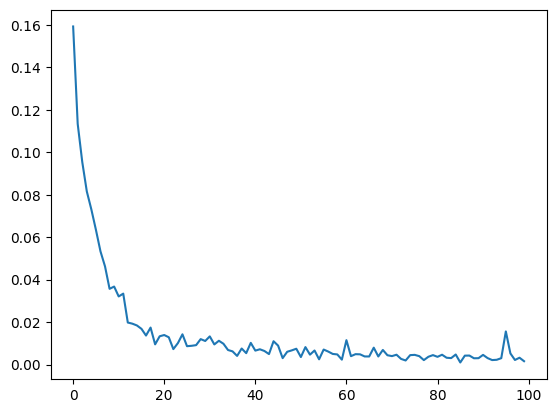

In [9]:
plt.plot(epoch_losses)

In [10]:
with torch.no_grad():
    pred_classes =train_model.predict_class(
        dataloader=test_loader, batch_size=batch_size, verbose=True
    ).to(device)

test_labels = labels[17000:].to(device)
print(test_labels.shape, pred_classes.shape)
print("Accuracy: ", accuracy_score(test_labels, pred_classes))
print("Precision: ", precision_score(test_labels, pred_classes))
print("Recall: ", recall_score(test_labels, pred_classes))
print("F1: ", f1_score(test_labels, pred_classes))

100%|██████████| 133/133 [00:04<00:00, 27.96it/s]

torch.Size([8500]) torch.Size([8500])
Accuracy:  tensor(0.9688, device='cuda:0')
Precision:  tensor(0.6961, device='cuda:0')
Recall:  tensor(0.8436, device='cuda:0')
F1:  tensor(0.7628, device='cuda:0')
